check data 

In [3]:
import h5py

def explore_group(group, group_name="Group"):
    """Explore a Group and print details about its content."""
    print(f"\n--- Exploring {group_name} ---")
    for key in group.keys():
        data = group[key]
        if isinstance(data, h5py.Group):  # 如果是子组，递归处理
            print(f"\nSubgroup: {key}")
            explore_group(data, group_name=f"{group_name}/{key}")
        else:  # 如果是数据集
            print(f"\nKey: {key}")
            print(f"  Shape: {data.shape}")
            print(f"  Dtype: {data.dtype}")
            # 打印部分数据
            if len(data.shape) == 1:  # 1D 数据
                print("  First 10 entries:", data[:10])
            elif len(data.shape) == 2:  # 2D 数据
                print("  First 10 rows and columns:")
                print(data[:10, :10])
            else:
                print("  Data is too large to display. Please load it for further analysis.")

def load_and_explore_h5(file_path):
    with h5py.File(file_path, 'r') as h5file:
        print("HDF5 File Keys:", list(h5file.keys()))

        # Explore X
        print("\n--- Exploring X ---")
        X = h5file['X']
        print(f"Shape of X: {X.shape}, Dtype: {X.dtype}")
        print("First 10 rows and columns of X:")
        print(X[:10, :10])

        # Explore obs
        if 'obs' in h5file:
            explore_group(h5file['obs'], group_name='obs')

        # Explore var
        if 'var' in h5file:
            explore_group(h5file['var'], group_name='var')

if __name__ == "__main__":
    file_path = '/Users/jacksonzhang/Desktop/program/BERMAD-main/Camp.h5'
    load_and_explore_h5(file_path)

HDF5 File Keys: ['X', 'obs', 'var']

--- Exploring X ---
Shape of X: (777, 16270), Dtype: float32
First 10 rows and columns of X:
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         2.8402476  5.759883
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.5850346  2.775021
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         4.8007703
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.2894627  5.1877165
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.17759892 4.5035205
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.  

In [4]:
with h5py.File(file_path, 'r') as h5file:
    print("Keys in 'var':", list(h5file['var'].keys()))  # 列出 var 中的子键
    if isinstance(h5file['var'], h5py.Group):
        for key in h5file['var'].keys():
            print(f"Key: {key}, Type: {type(h5file['var'][key])}")
            

Keys in 'var': ['gene_id']
Key: gene_id, Type: <class 'h5py._hl.dataset.Dataset'>


pre_processing

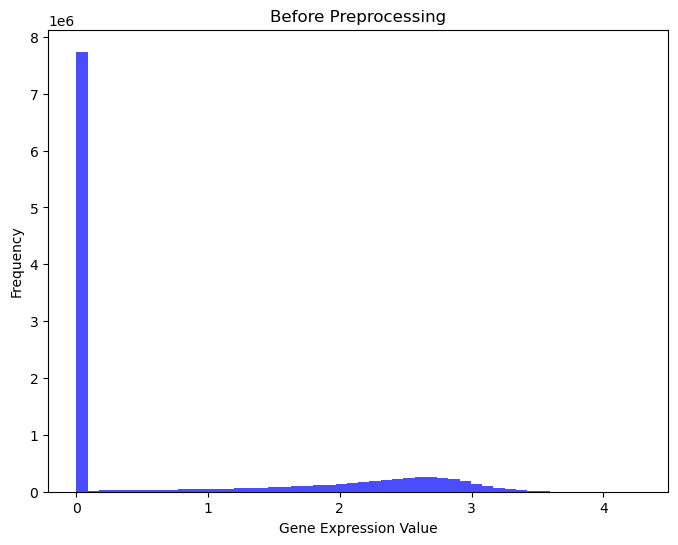

/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


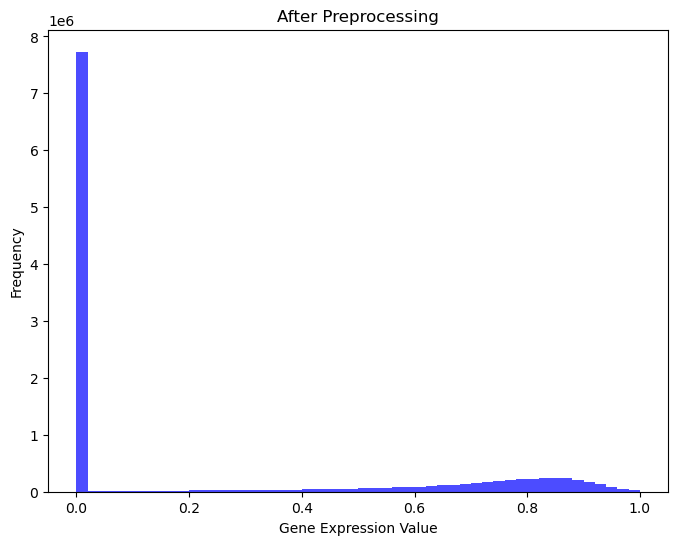


Dataset 1:
  Gene Expression Matrix Shape: (777, 15256)
  Number of Genes: 15256
  Sample Labels: [0 1 2 3 4 5 6 7 8 9]


In [5]:
import numpy as np
import h5py
from sklearn.preprocessing import scale, minmax_scale
import matplotlib.pyplot as plt

def read_h5(file_path, take_log):
    dataset = {}
    with h5py.File(file_path, 'r') as h5file:
        dataset['gene_exp'] = h5file['X'][:]
        gene_sym_all = [x.decode('utf-8') for x in h5file['var']['gene_id'][:]]
        dataset['gene_sym'] = gene_sym_all[:dataset['gene_exp'].shape[1]]
        dataset['sample_labels'] = np.arange(dataset['gene_exp'].shape[0])
        dataset['cell_labels'] = dataset['sample_labels']
        dataset['cluster_labels'] = np.zeros(dataset['gene_exp'].shape[0], dtype=int)
        if take_log:
            dataset['gene_exp'] = np.log2(dataset['gene_exp'] + 1)
    return dataset

def clean_gene_exp(dataset):
    """ Clean gene expression data by removing constant genes (std=0) and zero-expression samples """
    gene_std = np.std(dataset['gene_exp'], axis=0)  # Calculate std along genes (columns)
    valid_genes = gene_std > 1e-4
    dataset['gene_exp'] = dataset['gene_exp'][:, valid_genes]  # Keep valid genes
    dataset['gene_sym'] = [dataset['gene_sym'][i] for i in range(len(gene_std)) if valid_genes[i]]

    # Remove zero-expression samples
    nonzero_samples = np.any(dataset['gene_exp'] > 0, axis=1)  # Check rows for nonzero values
    dataset['gene_exp'] = dataset['gene_exp'][nonzero_samples, :]
    dataset['sample_labels'] = dataset['sample_labels'][nonzero_samples]
    return dataset

def plot_gene_exp_distribution(gene_exp, title="Gene Expression Distribution"):
    """ Plot histogram of gene expression values """
    plt.figure(figsize=(8, 6))
    plt.hist(gene_exp.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(title)
    plt.xlabel("Gene Expression Value")
    plt.ylabel("Frequency")
    plt.show()

def pre_processing(h5_file_list, pre_process_paras):
    take_log = pre_process_paras['take_log']
    standardization = pre_process_paras['standardization']
    scaling = pre_process_paras['scaling']
    dataset_list = []
    for file_path in h5_file_list:
        dataset = read_h5(file_path, take_log)
        dataset = clean_gene_exp(dataset)  # Remove constant genes and zero-expression samples
        plot_gene_exp_distribution(dataset['gene_exp'], title="Before Preprocessing")
        if standardization:
            scale(dataset['gene_exp'], axis=0, with_mean=True, with_std=True, copy=False)
        if scaling:
            minmax_scale(dataset['gene_exp'], feature_range=(0, 1), axis=0, copy=False)
        plot_gene_exp_distribution(dataset['gene_exp'], title="After Preprocessing")
        dataset_list.append(dataset)
    return dataset_list

if __name__ == '__main__':
    # Path to your HDF5 file
    file_path = '/Users/jacksonzhang/Desktop/program/BERMAD-main/Camp.h5'
    h5_file_list = [file_path]
    pre_process_paras = {'take_log': True, 'standardization': True, 'scaling': True}
    dataset_list = pre_processing(h5_file_list, pre_process_paras)
    for i, dataset in enumerate(dataset_list):
        print(f"\nDataset {i + 1}:")
        print(f"  Gene Expression Matrix Shape: {dataset['gene_exp'].shape}")
        print(f"  Number of Genes: {len(dataset['gene_sym'])}")
        print(f"  Sample Labels: {dataset['sample_labels'][:10]}")

In [6]:
#!/usr/bin/env python
# encoding: utf-8
import torch

# Minimum variance estimation to prevent division by zero
min_var_est = 1e-8

# Linear MMD: Linear kernel
def linear_mmd2(f_of_X, f_of_Y):
    """
    Compute MMD with a linear kernel.
    f_of_X: Tensor of shape [batch_size, features]
    f_of_Y: Tensor of shape [batch_size, features]
    """
    delta = f_of_X - f_of_Y
    loss = torch.mean((delta[:-1] * delta[1:]).sum(dim=1))
    return loss

# Polynomial MMD: Polynomial kernel
def poly_mmd2(f_of_X, f_of_Y, d=2, alpha=1.0, c=2.0):
    """
    Compute MMD with a polynomial kernel.
    f_of_X: Tensor of shape [batch_size, features]
    f_of_Y: Tensor of shape [batch_size, features]
    d: Degree of the polynomial kernel
    alpha: Scaling factor
    c: Constant offset
    """
    K_XX = (alpha * (f_of_X[:-1] * f_of_X[1:]).sum(dim=1) + c)
    K_XX_mean = torch.mean(K_XX.pow(d))

    K_YY = (alpha * (f_of_Y[:-1] * f_of_Y[1:]).sum(dim=1) + c)
    K_YY_mean = torch.mean(K_YY.pow(d))

    K_XY = (alpha * (f_of_X[:-1] * f_of_Y[1:]).sum(dim=1) + c)
    K_XY_mean = torch.mean(K_XY.pow(d))

    K_YX = (alpha * (f_of_Y[:-1] * f_of_X[1:]).sum(dim=1) + c)
    K_YX_mean = torch.mean(K_YX.pow(d))

    return K_XX_mean + K_YY_mean - K_XY_mean - K_YX_mean

# RBF Kernel computation
def _mix_rbf_kernel(X, Y, sigma_list):
    """
    Compute the mixed RBF kernel matrix.
    X: Tensor of shape [batch_size, features]
    Y: Tensor of shape [batch_size, features]
    sigma_list: List of bandwidths for RBF kernels
    """
    assert X.size(0) == Y.size(0), "Batch sizes of X and Y must match."
    m = X.size(0)

    Z = torch.cat((X, Y), dim=0)
    ZZT = torch.mm(Z, Z.t())
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()

    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * exponent)

    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)

# Mixed RBF MMD
def mix_rbf_mmd2(X, Y, sigma_list, biased=True):
    """
    Compute MMD with a mixed RBF kernel.
    X: Tensor of shape [batch_size, features]
    Y: Tensor of shape [batch_size, features]
    sigma_list: List of bandwidths
    """
    K_XX, K_XY, K_YY, _ = _mix_rbf_kernel(X, Y, sigma_list)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)

# Mixed RBF MMD with ratio computation
def mix_rbf_mmd2_and_ratio(X, Y, sigma_list, biased=True):
    """
    Compute MMD with a mixed RBF kernel and return the ratio.
    """
    K_XX, K_XY, K_YY, _ = _mix_rbf_kernel(X, Y, sigma_list)
    return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)

# Helper function to compute MMD
def _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)  # Batch size
    if const_diagonal is not False:
        sum_diag_X = sum_diag_Y = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)
        diag_Y = torch.diag(K_YY)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sum = K_XX.sum() - sum_diag_X
    Kt_YY_sum = K_YY.sum() - sum_diag_Y
    K_XY_sum = K_XY.sum()

    if biased:
        mmd2 = (Kt_XX_sum + sum_diag_X) / (m * m) + (Kt_YY_sum + sum_diag_Y) / (m * m) - 2.0 * K_XY_sum / (m * m)
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))) + (Kt_YY_sum / (m * (m - 1))) - 2.0 * K_XY_sum / (m * m)
    return mmd2

# MMD and variance estimation
def _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    mmd2, var_est = _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=const_diagonal, biased=biased)
    loss = mmd2 / torch.sqrt(torch.clamp(var_est, min=min_var_est))
    return loss, mmd2, var_est

# Variance estimation for MMD
def _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)
    diag_X = torch.diag(K_XX) if const_diagonal is False else const_diagonal
    diag_Y = torch.diag(K_YY) if const_diagonal is False else const_diagonal
    sum_diag_X = torch.sum(diag_X)
    sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sum = K_XX.sum() - sum_diag_X
    Kt_YY_sum = K_YY.sum() - sum_diag_Y
    K_XY_sum = K_XY.sum()

    var_est = 2.0 / (m**2 * (m - 1)**2) * (Kt_XX_sum**2 + Kt_YY_sum**2) - (4.0 * m - 6.0) / (m**3 * (m - 1)**3) * (Kt_XX_sum + Kt_YY_sum)**2
    return mmd2, var_est

In [17]:
import os
import h5py
import numpy as np
import pandas as pd
import random
import pickle
import torch
from sklearn.preprocessing import scale, minmax_scale
from BERMAD import training, testing
from datetime import datetime

# 固定随机种子
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 定义训练的超参数
nn_params = {
    'code_dim': 20,
    'batch_size': 50,
    'base_lr': 1e-3,
    'lr_step': 200,
    'momentum': 0.9,
    'l2_decay': 5e-5,
    'gamma': 1.0,
    'num_epochs': 2000,
    'alpha': 0.1,
    'beta': 0.1,
    'delta': 0.5,
    'cuda': torch.cuda.is_available()
}

def read_h5(file_path, take_log=True):
    """从 HDF5 文件中读取数据"""
    dataset = {}
    with h5py.File(file_path, 'r') as h5file:
        dataset['gene_exp'] = h5file['X'][:]
        dataset['gene_sym'] = [
            x.decode('utf-8') if isinstance(x, bytes) else str(x)
            for x in h5file['var']['gene_id'][:]
        ]
        dataset['sample_labels'] = np.arange(dataset['gene_exp'].shape[0])
        dataset['cell_labels'] = dataset['sample_labels']
        dataset['cluster_labels'] = np.zeros(dataset['gene_exp'].shape[0], dtype=int)
        if take_log:
            dataset['gene_exp'] = np.log2(dataset['gene_exp'] + 1)
    return dataset

def preprocess_dataset(dataset, standardization=True, scaling=True):
    """预处理数据集"""
    gene_exp = dataset['gene_exp']
    std_dev = np.std(gene_exp, axis=0)
    valid_features = std_dev > 1e-6
    dataset['gene_exp'] = gene_exp[:, valid_features]
    dataset['gene_sym'] = [dataset['gene_sym'][i] for i in range(len(valid_features)) if valid_features[i]]
    if standardization:
        scale(dataset['gene_exp'], axis=1, with_mean=True, with_std=True, copy=False)
    if scaling:
        minmax_scale(dataset['gene_exp'], feature_range=(0, 1), axis=1, copy=False)
    return dataset

def generate_cluster_similarity(dataset, cluster_similarity_file):
    """生成 cluster 相似性矩阵"""
    print("Calculating similarity matrix...")
    cluster_similarity = np.corrcoef(dataset['gene_exp'])
    with open(cluster_similarity_file, 'wb') as f:
        pickle.dump(cluster_similarity, f)
    print(f"Cluster similarity file saved to {cluster_similarity_file}")

def training_with_checks(dataset_list, cluster_pairs, nn_params):
    """包含检查的训练函数"""
    for dataset in dataset_list:
        gene_exp = dataset['gene_exp']
        cluster_labels = dataset['cluster_labels']
        
        # 打印数据形状
        print("gene_exp shape:", gene_exp.shape)
        print("cluster_labels shape:", cluster_labels.shape)

        # 确保索引一致
        idx = cluster_labels > 0  # 示例筛选条件
        if len(idx) != gene_exp.shape[0]:
            print(f"Adjusting idx length: {len(idx)} to match gene_exp rows: {gene_exp.shape[0]}")
            idx = np.ones(gene_exp.shape[0], dtype=bool)  # 默认保留所有行

        # 继续训练逻辑
        try:
            torch_dataset = torch.utils.data.TensorDataset(
                torch.FloatTensor(gene_exp[idx, :]), torch.LongTensor(cluster_labels[idx]))
            # 继续训练逻辑，例如加载 dataloader
        except Exception as e:
            print(f"Error during dataset creation: {e}")
            raise

def main(data_file, cluster_similarity_file, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    print(f"Loading and preprocessing dataset: {data_file}")
    dataset = read_h5(data_file)
    dataset = preprocess_dataset(dataset)

    print(f"Cluster similarity file: {cluster_similarity_file}")
    if not os.path.exists(cluster_similarity_file):
        print("Cluster similarity file not found. Generating...")
        generate_cluster_similarity(dataset, cluster_similarity_file)

    with open(cluster_similarity_file, 'rb') as f:
        cluster_pairs = pickle.load(f)

    print("Starting model training...")
    nn_params['num_inputs'] = len(dataset['gene_sym'])
    try:
        model, loss_total, loss_reconstruct, loss_transfer = training_with_checks([dataset], cluster_pairs, nn_params)
    except Exception as e:
        print(f"Training failed: {e}")
        return

    loss_file = os.path.join(output_folder, "loss.npy")
    np.save(loss_file, {"total_loss": loss_total, "reconstruction_loss": loss_reconstruct, "transfer_loss": loss_transfer})
    print(f"Training losses saved to {loss_file}")

    print("Testing the model...")
    code_list = testing(model, [dataset], nn_params)

    code_file = os.path.join(output_folder, "codes.pkl")
    with open(code_file, 'wb') as f:
        pickle.dump(code_list, f)
    print(f"Encoded results saved to {code_file}")

if __name__ == "__main__":
    data_file = "./Camp.h5"
    cluster_similarity_file = "./cluster_similarity.pkl"
    output_folder = os.path.join("./output", datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

    # 执行主程序
    main(data_file, cluster_similarity_file, output_folder)

Loading and preprocessing dataset: ./Camp.h5
Cluster similarity file: ./cluster_similarity.pkl
Starting model training...
gene_exp shape: (777, 15257)
cluster_labels shape: (777,)
Training failed: cannot unpack non-iterable NoneType object


/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:277: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
